# Training MODEL to play 2048

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from game_2048 import game_2048
import random
import copy
import matplotlib.pyplot as plt

/home/laserhammer/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## NN for Estimation of action value function
The small neural network defined here gives is used to estimate the action value function for the 4 possible actions (up,down,left.right). The model will be evaluated over different NN architecture (activation functions and depth of layers). In this approach as there are no image input and the states are finite, I am using numeric data to represent the state (as this is suppose to be a Project based on research paper Playing with ATARI). Later implimentations will also have same games state value in terms of image rather than numeric data (in this case the matrix itself)

In [ ]:
class Small_neural_net(nn.Module):
    def __init__(self):
        super(Small_neural_net,self).__init__()
        self.layer1 = nn.Linear(16,32)
        self.layer2 = nn.Linear(32,48)
        self.layer3 = nn.Linear(48,64)
        self.layer4 = nn.Linear(64,32)
        self.layer5 = nn.Linear(32,10)
        self.layer6 = nn.Linear(10,4)
    
    def forward(self,x):
        x = F.leaky_relu(self.layer1(x))
        x = F.leaky_relu(self.layer2(x))
        x = F.leaky_relu(self.layer3(x))
        x = F.leaky_relu(self.layer4(x))
        x = F.leaky_relu(self.layer5(x))
        x = self.layer6(x)
        return x

### Initialise important parameters

In [3]:
def normalise_input(state_matrix,n):
    one = np.ones_like(state_matrix)
    state_matrix = np.add(state_matrix,one)
    filled = np.full_like(state_matrix,n)
    normaised_state = np.log2(state_matrix)/np.log2(filled)

    normaised_state = torch.tensor(normaised_state.flatten(), dtype=torch.float32).unsqueeze(0)
    
    return normaised_state



def eta_greedy(greedy,action_values):
    action_values = action_values.tolist()
    actions = [0,1,2,3]
    if random.random()< greedy:
        return random.choice(actions)
    else:
        max_val = max(action_values)
        max_indices = [i for i, v in enumerate(action_values) if v == max_val]
        return random.choice(max_indices)

        




### Loss Function: 
The loss function used will be MSE and as we are estimating action value functions we will be taking from the experiecnce buffer (this will be a finite buffer, you will know why)

The NN will run till the terminal state is hit that is when the matrix dosent change after actions are 

In [ ]:
reward = 0
runs = 1000
model = Small_neural_net()
criteriation = nn.MSELoss()
game = game_2048()
buffer_game = game_2048()
model_eval = copy.deepcopy(model)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
gamma = 0.99
replay_memory = []
action = [0,1,2,3]
loss_his = []
reward_his = []

In [ ]:
#filling the buffer
for i in range(50):
        #initialise the replay memory
        #run the model with copy to buffer up memory
        s_t = buffer_game.matrix.copy()
        a_t = random.choice(action)
        r_t = buffer_game.run(a_t)
        s_t_1 = buffer_game.matrix.copy()
        #store the replay in the memory
        replay_memory.append([s_t,a_t,r_t,s_t_1])
        if r_t == -1:
            buffer_game.initialise()
        

In [6]:
for run in tqdm(range(runs)):
    l = []
    r_h =  []
    flag = 0
    game.initialise()
    while flag != -1:
        #train the model
        s_t = game.matrix.copy()
        #predict action value function
        q_t = model(normalise_input(s_t,2048))
        #choose an action based on action value functions predicted (throught eta greedy)
        a_t = eta_greedy(0.2,q_t)
        r_t = game.run(a_t)
        # override reward
        if(r_t == 0):
            r_t = -0.1
        
        s_t_1 = game.matrix.copy()
        #save the the experience in buffer 
        replay_memory.pop()
        replay_memory.append([s_t,a_t,r_t,s_t_1])

        #training
        #sample mini batch from replay
        experience = random.choice(replay_memory)
        if(run%2 == 0):
            model_eval = copy.deepcopy(model)
        with torch.no_grad():
            s_m,a_m,r_m,s_m_1 = experience
            q_t_1 = model_eval(normalise_input(s_m_1,2048))
            q_max = max(q_t_1[0])
            # if the next state in experience is terminal then there is no future reward
            # in this game to indicate terminal sate the reward outputs -1 
            # (this has to be treated as a flag and not a reward hence the override with 0)
            if(r_m == -1):
                y = -1
            else:
                r = torch.tensor(r_m, dtype=torch.float32)
                gamma = torch.tensor(gamma, dtype=torch.float32)
                y = r + gamma*q_max
        # now that the predicted value has been calculated train the model
        #the target value is a tensor of size (1,4), so the update has to happen for the chosen action
        # taht is the action value update has to happen from the chosen action
        target = q_t.clone().detach()
        target[0,a_t] = y
        loss = criteriation(q_t,target)
        l.append(loss.item())
        r_h.append(r_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #append the loss and reward for model train evaluation
        flag = r_t
        # to see significant changes in training take sample model from time to time
        if(run == 0):
            untrained_model = copy.deepcopy(model)
        if(run == runs/2):
            fifty_model = copy.deepcopy(model)
        if(run == int(runs*3/4)):
            seventy_five = copy.deepcopy(model)

    loss_his.append((sum(l)/len(l)))
    reward_his.append(sum(r_h))
    


  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_5666/2766983617.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma = torch.tensor(gamma, dtype=torch.float32)
100%|██████████| 1000/1000 [33:05<00:00,  1.99s/it] 


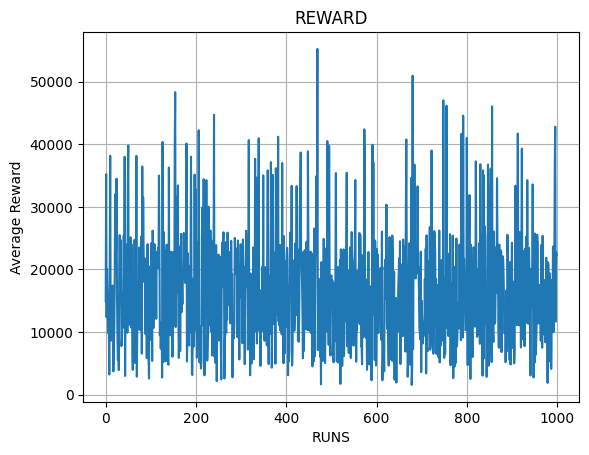

In [7]:
plt.xlabel("RUNS")
plt.ylabel("Average Reward")
plt.plot(reward_his)
plt.title("REWARD")
plt.grid(True)
plt.show()

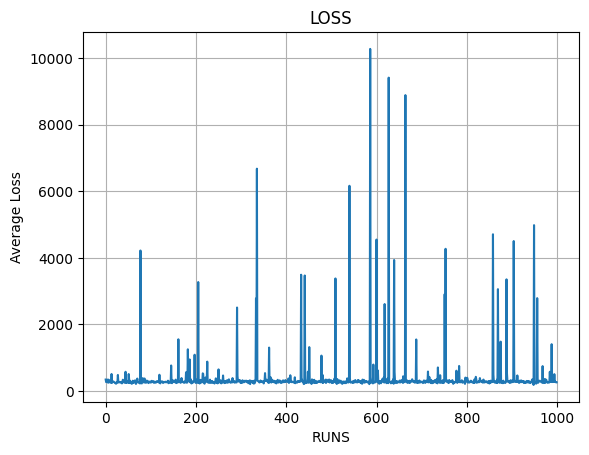

In [8]:
plt.xlabel("RUNS")
plt.ylabel("Average Loss")
plt.plot(loss_his)
plt.title("LOSS")
plt.grid(True)
plt.show()

# Evaluating model

In [71]:
def eval(model,game,run):
    rewards = []
    for _ in tqdm(range(run)):
        game.initialise()
        r_t = 0
        ep_rewards = []
        while r_t != -1:
            s_t = game.matrix.copy()
            q_t = model(normalise_input(s_t, 2048))
            a_t = eta_greedy(0.2, q_t)
            r_t = game.run(a_t)
            ep_rewards.append(r_t)
        rewards.append(np.mean(ep_rewards))
    return rewards


In [72]:
#untrained

average_reward_untrained = eval(untrained_model,game,100)

100%|██████████| 100/100 [00:07<00:00, 13.78it/s]


In [73]:
#fifty % trained
fifty_model_average_reward = eval(fifty_model,game,100)

100%|██████████| 100/100 [00:06<00:00, 14.62it/s]


In [74]:
# 75% trained model
seventy_five_average_reward = eval(seventy_five,game,100)

100%|██████████| 100/100 [00:07<00:00, 14.04it/s]


In [ ]:
#trained modle
reward = eval(model,game,100)

100%|██████████| 100/100 [00:07<00:00, 14.28it/s]


Reward

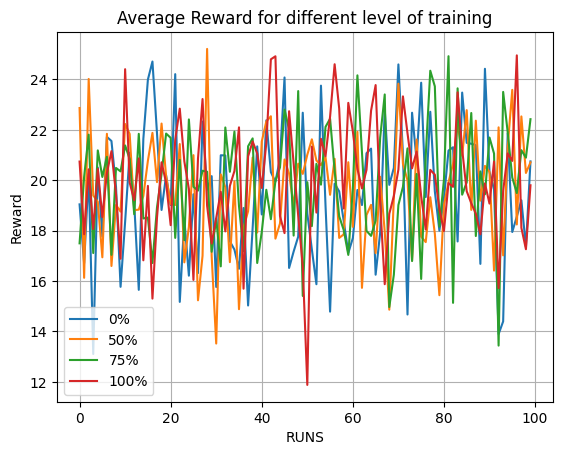

In [85]:
plt.xlabel("RUNS")
plt.ylabel("Reward")
plt.plot(average_reward_untrained,label = "0%")
plt.plot(fifty_model_average_reward,label = "50%")
plt.plot(seventy_five_average_reward,label = "75%")
plt.plot(reward,label = "100%")
plt.title("Average Reward for different level of training")
plt.grid(True)
plt.legend()
plt.show()

## Max value of a cell achieved
instead of looking at average reqward to see learning we can look into max value porduced after every action to see moddel performance/learning


In [86]:
def max_val(model, game, runs):
    max_vals = []
    for _ in tqdm(range(runs), desc="Evaluating max tile"):
        game.initialise()
        r_t = 0
        m = []  # store all max tiles for this run
        while r_t != -1 and r_t<=2048:
            s_t = game.matrix.copy()
            q_t = model(normalise_input(s_t, 2048))
            a_t = eta_greedy(0.2, q_t)
            r_t = game.run(a_t)
            
            # track max tile
            max_tile = np.max(game.matrix)
            if max_tile>2048:
                continue
            m.append(max_tile)
        
        # record the highest tile in this run
        max_vals.append(max(m))

    return max_vals


In [87]:
max_un = max_val(untrained_model,game,100)

Evaluating max tile: 100%|██████████| 100/100 [00:06<00:00, 16.26it/s]


In [79]:
trained_max_tile_value = max_val(model,game,100)

Evaluating max tile: 100%|██████████| 100/100 [00:05<00:00, 17.04it/s]


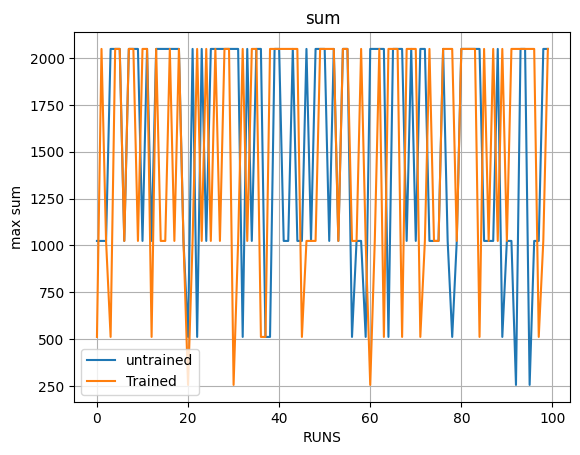

In [ ]:
plt.xlabel("RUNS")
plt.ylabel("max tile value")
plt.plot(max_un,label = "untrained")
plt.plot(trained_max_tile_value,label = "Trained")
plt.title("Max_tile of run")
plt.grid(True)
plt.legend()
plt.show()